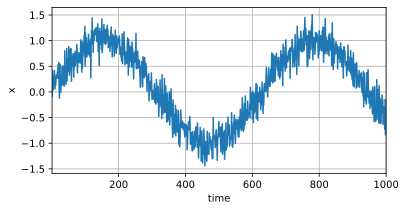

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

#用正弦函数加一些噪音来生成时序序列
#torch.normal(mean, std, size)
T=1000
time=torch.arange(1,T+1,dtype=torch.float32)
x=torch.sin(0.01*time)+torch.normal(0,0.2,(T,))
d2l.plot(time,[x],'time','x',xlim=[1,1000],figsize=(6,3))

In [ ]:
tau=4 #时间步长，表示每个样本的特征窗口大小
features=torch.zeros((T-tau,tau)) #996*4
#相当于是有996个样本，每个样本4个特征

for i in range(tau):
    features[:,i]=x[i:T-tau+i]
    #features第0列为x[0:996]
    #features第1列为x[1:997]
    #features第2列为x[2:998]
    #features第3列为x[3:999]
labels=x[tau:].reshape((-1,1)) #labels.shape:996*1

batch_size,n_train=16,600
train_iter=d2l.load_array((features[:n_train],labels[:n_train]),batch_size,is_train=True)
labels.shape

torch.Size([996, 1])

In [ ]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [4]:
def train(net,train_iter,loss,epochs,lr):
    trainer=torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l=loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f'epoch{epoch+1},'
              f'loss:{d2l.evaluate_loss(net,train_iter,loss):f}')
net=get_net()
train(net,train_iter,loss,5,0.01)

epoch1,loss:0.055526
epoch2,loss:0.048555
epoch3,loss:0.049232
epoch4,loss:0.047328
epoch5,loss:0.053979


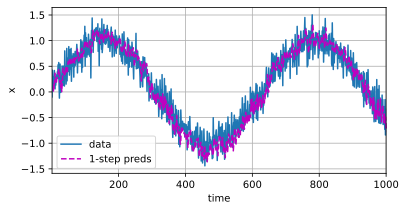

In [ ]:
#使用模型，单步预测 one-step-ahead prediction
onestep_preds=net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))


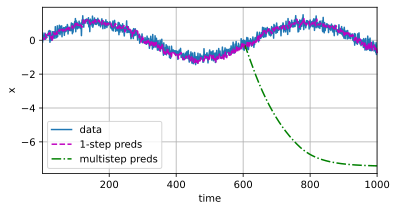

In [ ]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

#导致原因：每次预测都会有一定的误差，误差不断叠加

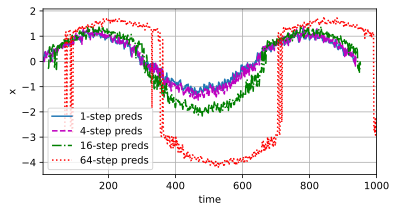

In [10]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))